In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from collections import Counter

# 1. Merging the two datasets:

In [59]:
packages_df = pd.read_csv('datasets/packages_data_2023_2025.csv', delimiter=';', encoding='latin-1')
receptacl_df = pd.read_csv('datasets/receptacle_data_2023_2025.csv', delimiter=';', encoding='latin-1')

In [60]:
print(packages_df.columns)

Index(['RECPTCL_FID', 'MAILITM_FID', 'date', 'établissement_postal',
       'EVENT_TYPE_CD', 'next_établissement_postal'],
      dtype='object')


In [61]:
print(receptacl_df.columns)

Index(['ï»¿RECPTCL_FID', 'date', 'etablissement_postal', 'EVENT_TYPECD',
       'nextetablissement_postal'],
      dtype='object')


In [62]:
receptacl_df.rename(columns={'ï»¿RECPTCL_FID': 'RECPTCL_FID'}, inplace=True)

In [63]:
df = packages_df[packages_df['RECPTCL_FID']
                                   .isin(receptacl_df['RECPTCL_FID'].unique())]

print(df.shape)
df.head()

(844351, 6)


,RECPTCL_FID,MAILITM_FID,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
4,FRCDGADZALGDAUN40553006010061,1A02349441537,2024-12-19 11:05:00.000,NaN,12,ETAB_2389
5,FRCDGADZALGDAUN32487005010095,1A09158628029,2023-12-01 07:45:00.000,NaN,12,ETAB_2389
6,FRCDGADZALGDAUN32105001010038,1A09165695052,2023-03-18 08:55:00.000,NaN,12,ETAB_2389
7,FRCDGADZALGDAUN40272001010036,1A10720195245,2024-06-23 08:45:00.000,NaN,12,ETAB_2389
8,FRCDGADZALGDAUN32073001000051,1A12468884825,2023-02-23 08:55:00.000,NaN,12,ETAB_2389


#  2. Data Cleaning:

Here is how I cleaned the dataset 

### 1. Fix Loading Errors
* **What I did:** Used `Latin-1` encoding instead of the default.
* **Why:** The file has French characters (like *'é'*) that were crashing the standard loader.

### 2. Basic Cleanup
* **What I did:** Removed invisible spaces from IDs and converted the `date` column to a real time format.
* **Why:** We need clean text to match IDs correctly, and we need real dates to calculate delivery times.

### 3. Remove "Ghost" Duplicates
* **What I did:** Deleted rows that had the exact same Package ID, Time, and Location.
* **Why:** The system sometimes scans a package 3 times in one second. These are glitches that inflate our numbers.

### 4. Fix " trasportation " Errors
* **What I did:** Removed events where a package moved between two different facilities in **less than 10 minutes**.
* **Why:** It's physically impossible to travel that fast. These are data errors that would mess up our "Average Delivery Time" charts.

### 5. Remove Infinite Loops
* **What I did:** Removed packages that had more than **50 events**.
* **Why:** These packages are likely lost or stuck in a loop. Including them would ruin our average statistics.

In [64]:
# removing whitespaces from string columns
df_obj = df.select_dtypes(['object'])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

#converting date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

#handling missing values in 'etablissement_postal' and 'next_etablissement_postal'
#filling missing values with 'Unknown' or 'N/A' cuz we deal with them later
df['établissement_postal'] = df['établissement_postal'].fillna('Unknown')
df['next_établissement_postal'] = df['next_établissement_postal'].fillna('N/A')

C:\Users\ADM\AppData\Local\Temp\ipykernel_29700\158845636.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
C:\Users\ADM\AppData\Local\Temp\ipykernel_29700\158845636.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
C:\Users\ADM\AppData\Local\Temp\ipykernel_29700\158845636.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [65]:
# remove real duplicates 
subset_cols = ['MAILITM_FID', 'date', 'EVENT_TYPE_CD', 'établissement_postal']
df = df.drop_duplicates(subset=subset_cols, keep='first')
print(f"Rows after duplicate removal: {len(df)}")

# deal with impossible moves
# Dwhen we move to DIFFERENT location in < 10 minutes 
df = df.sort_values(by=['MAILITM_FID', 'date'])
df['time_diff_sec'] = df.groupby('MAILITM_FID')['date'].diff().dt.total_seconds()
df['prev_etab'] = df.groupby('MAILITM_FID')['établissement_postal'].shift(1)
#we exclude 
noise_mask = (
    (df['time_diff_sec'] < 600) &              
    (df['time_diff_sec'] >= 0) &                
    (df['établissement_postal'] != df['prev_etab']) & 
    (df['prev_etab'] != 'Unknown') &            
    (df['établissement_postal'] != 'Unknown')   
)

moves_errors = df[noise_mask]
print(f"Found {len(moves_errors)} 'impossible moves' errors (impossible speed). Removing them...")
df = df[~noise_mask]

#deal with outliers (packages stuck in loops)
#packages with > 50 events are likely stuck in a processing loop.
event_counts = df.groupby('MAILITM_FID').size()
outlier_ids = event_counts[event_counts > 50].index

print(f"Found {len(outlier_ids)} packages stuck in loops (>50 events). Removing them...")
df = df[~df['MAILITM_FID'].isin(outlier_ids)]

# we remove the columns used for calculations
df = df.drop(columns=['time_diff_sec', 'prev_etab'])
print(f"Final Cleaned Row Count: {len(df)}")
df.to_csv('datasets/cleaned_packages_data_final.csv', index=False, sep=';')

Rows after duplicate removal: 819262
Found 3255 'impossible moves' errors (impossible speed). Removing them...
Found 1 packages stuck in loops (>50 events). Removing them...
Final Cleaned Row Count: 815947


# 3. DATA TRANSFORMATION:

In [66]:
df.head()

,RECPTCL_FID,MAILITM_FID,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
4,FRCDGADZALGDAUN40553006010061,1A02349441537,2024-12-19 11:05:00,Unknown,12,ETAB_2389
5,FRCDGADZALGDAUN32487005010095,1A09158628029,2023-12-01 07:45:00,Unknown,12,ETAB_2389
6,FRCDGADZALGDAUN32105001010038,1A09165695052,2023-03-18 08:55:00,Unknown,12,ETAB_2389
7,FRCDGADZALGDAUN40272001010036,1A10720195245,2024-06-23 08:45:00,Unknown,12,ETAB_2389
8,FRCDGADZALGDAUN32073001000051,1A12468884825,2023-02-23 08:55:00,Unknown,12,ETAB_2389


## 1. Extract Meaningful Postal Features:

In [67]:
def split_recptcl(x):
    return pd.Series({
        'origin_country': x[0:2],
        'operation_code': x[2:6],
        'dest_country': x[6:8],
        'dest_facility': x[8:13],
        'unit_code': x[13:15],
        'dispatch_batch': x[15:19],
        'bag_number': x[19:24],
        'seq_number': x[24:]
    })

recptcl_features = df['RECPTCL_FID'].apply(split_recptcl)
df = pd.concat([df, recptcl_features], axis=1)

print("RECPTCL_FID successfully decoded.")
print(df[['RECPTCL_FID','origin_country','operation_code','dest_facility']].head())


RECPTCL_FID successfully decoded.
                     RECPTCL_FID origin_country operation_code dest_facility
4  FRCDGADZALGDAUN40553006010061             FR           CDGA         ALGDA
5  FRCDGADZALGDAUN32487005010095             FR           CDGA         ALGDA
6  FRCDGADZALGDAUN32105001010038             FR           CDGA         ALGDA
7  FRCDGADZALGDAUN40272001010036             FR           CDGA         ALGDA
8  FRCDGADZALGDAUN32073001000051             FR           CDGA         ALGDA


The column `RECPTCL_FID` is a complex logistics identifier provided by Algérie Poste.
Although it does not strictly follow the official UPU S10 standard, it is a structured
routing key that encodes multiple operational attributes inside it.

Since the official decoding specification was not provided to us, we adopted a 
reverse-engineering based assumption widely used in logistics analytics:

| Field | Meaning |
|-------|--------|
origin_country | international origin of the dispatch  
operation_code | routing/service category
dest_country | always DZ (Algeria)
dest_facility | main Algerian entry or processing hub
unit_code | processing or routing unit
dispatch_batch | batch / routing dispatch group
bag_number | bag identifier inside the dispatch
seq_number | logical sequence identifier

Why this step? 

Extracting these hidden fields allows us to:
• create meaningful analytical and ML features  
• support better sampling and stratification  
• analyze postal routing behavior  
• preserve operational intelligence hidden inside encrypted identifiers

## 2. Date Intelligence Features:

In [68]:
df["date"] = pd.to_datetime(df["date"], errors='coerce')
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.to_period("M").astype(str)
df["day"] = df["date"].dt.day
df["day_of_week"] = df["date"].dt.dayofweek
df["hour"] = df["date"].dt.hour
df["is_weekend"] = df["day_of_week"].isin([5,6]).astype(int)

print("Time features extracted.")


Time features extracted.


Working directly with a raw `date` column is not convenient for statistical analysis
or machine learning. Instead, we extract interpretable temporal components:

• `year`, `month`, `day`, `hour`
• `day_of_week` (0 = Monday … 6 = Sunday)
• `is_weekend` flag

Why this step?

These features allow us to:
✓ identify seasonal trends and workload peaks  
✓ detect operational delays by day / month / hour  
✓ support stratified sampling based on time  
✓ prepare the dataset for future prediction tasks such as:
  – delivery time estimation  
  – anomaly detection  
  – workload planning

## 3. Package Complexity Feature:

In [69]:
pkg_event_counts = df.groupby("MAILITM_FID").size().rename("event_count")
df = df.merge(pkg_event_counts, on="MAILITM_FID", how="left")

bins = [0, 5, 10, 20, 50, 9999]
labels = ["0-5","6-10","11-20","21-50","50+"]
df["event_level"] = pd.cut(df["event_count"], bins=bins, labels=labels)

print("Package lifecycle feature created.")


Package lifecycle feature created.


Here we compute how many operational events each package experienced:

`event_count = number of records per MAILITM_FID`

Then we transform it into meaningful lifecycle categories:

| Range | Meaning |
|--------|--------|
0–5  | simple / fast journey
6–10 | normal processing
11–20 | moderately complex
21–50 | highly complex
50+ | abnormal / problematic

Why this step?

This feature helps us:
• understand logistics complexity  
• support stratified sampling (we must keep both simple + complex journeys)
• analyze operational efficiency  
• support anomaly detection in later phases  

## 4. Stratified Sampling:

### 4.1. Facility Load Distribution (dest_facility):

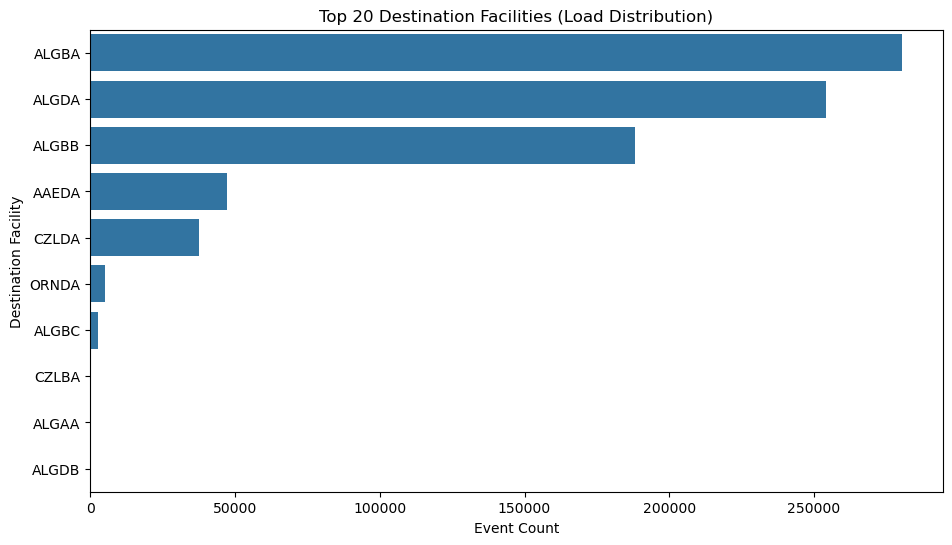

In [70]:
plt.figure(figsize=(11,6))
top_fac = df["dest_facility"].value_counts().head(20)
sns.barplot(x=top_fac.values, y=top_fac.index)
plt.title("Top 20 Destination Facilities (Load Distribution)")
plt.xlabel("Event Count")
plt.ylabel("Destination Facility")
plt.show()


This visualization shows how traffic is distributed across postal facilities.
We observe that a few facilities (e.g., ALGBA, ALGDA) process a very large volume,
while others have lower but still operationally important traffic.

Conclusion:
We must stratify sampling using `dest_facility`
to preserve rare but important facility behaviors.

### 4.2. Event Type Behavior (EVENT_TYPE_CD):

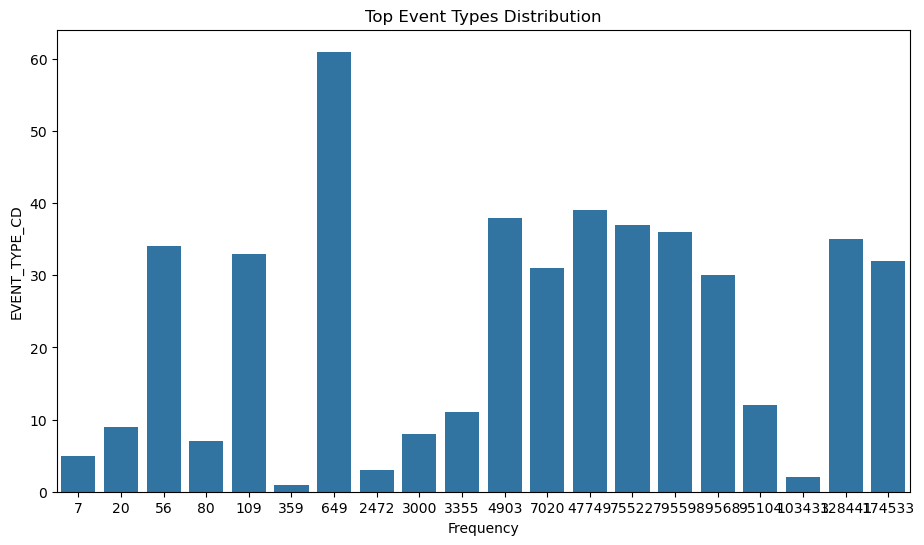

In [71]:
plt.figure(figsize=(11,6))
top_events = df["EVENT_TYPE_CD"].value_counts().head(20)
sns.barplot(x=top_events.values, y=top_events.index)
plt.title("Top Event Types Distribution")
plt.xlabel("Frequency")
plt.ylabel("EVENT_TYPE_CD")
plt.show()


Event codes represent different processing actions (sorting, transfer, arrival,
exception handling, etc.). Some event codes appear extremely frequently,
while others are rare but critical for understanding failures or special routing.

Conclusion:
We must stratify by `EVENT_TYPE_CD`
to ensure we do not lose rare operational behaviors.


### 4.3. Routing / Service Type (operation_code):

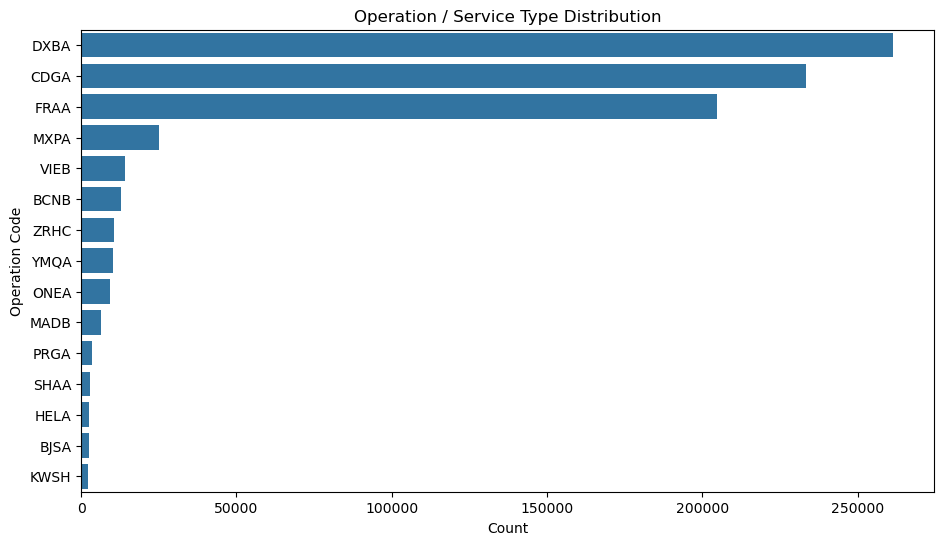

In [72]:
plt.figure(figsize=(11,6))
top_ops = df["operation_code"].value_counts().head(15)
sns.barplot(x=top_ops.values, y=top_ops.index)
plt.title("Operation / Service Type Distribution")
plt.xlabel("Count")
plt.ylabel("Operation Code")
plt.show()


Operation codes describe routing or service classes.
We see dominant routing categories (e.g., DXBA, CDGA),
but less frequent ones still represent real network behavior.

Conclusion:
We also stratify using `operation_code`
to retain routing diversity in the sample.

### 4.4. Time Stability (Monthly):

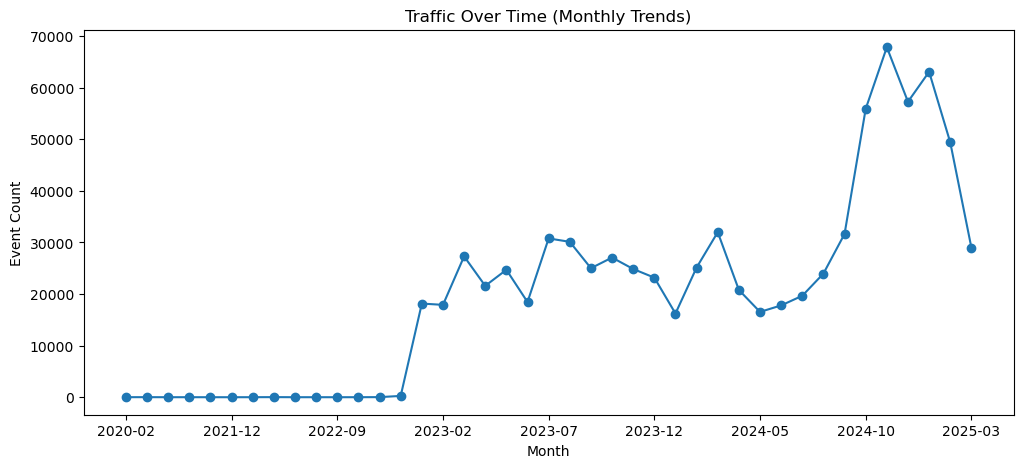

In [73]:
monthly = df.groupby("month").size()

plt.figure(figsize=(12,5))
monthly.plot(kind="line", marker="o")
plt.title("Traffic Over Time (Monthly Trends)")
plt.xlabel("Month")
plt.ylabel("Event Count")
plt.show()


Traffic volume is not constant over time. We observe variations between months,
which may correspond to seasonal peaks, operational disruptions, or business cycles.

Conclusion:
We stratify by `month`
to preserve temporal dynamics of the logistics system.

### 4.5. Package Complexity (Events Per Package):

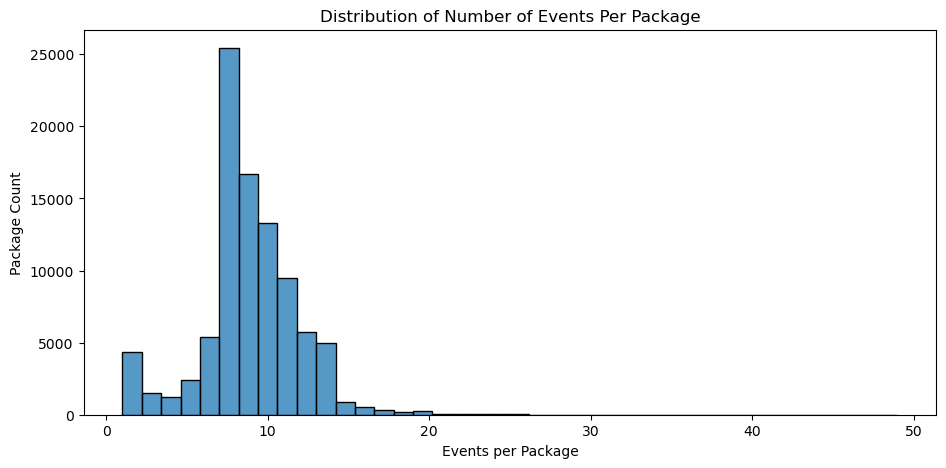

In [74]:
pkg_events = df.groupby("MAILITM_FID").size()

plt.figure(figsize=(11,5))
sns.histplot(pkg_events, bins=40)
plt.title("Distribution of Number of Events Per Package")
plt.xlabel("Events per Package")
plt.ylabel("Package Count")
plt.show()


Most packages have a normal number of events, but some have much longer histories.
These may correspond to re-routing, delays, or operational loops.

Conclusion:
We stratify using `event_level`
to ensure representation of both normal and complex journeys.


### 4.6. Origin Country Analysis:


Origin Country Analysis - 34 unique countries


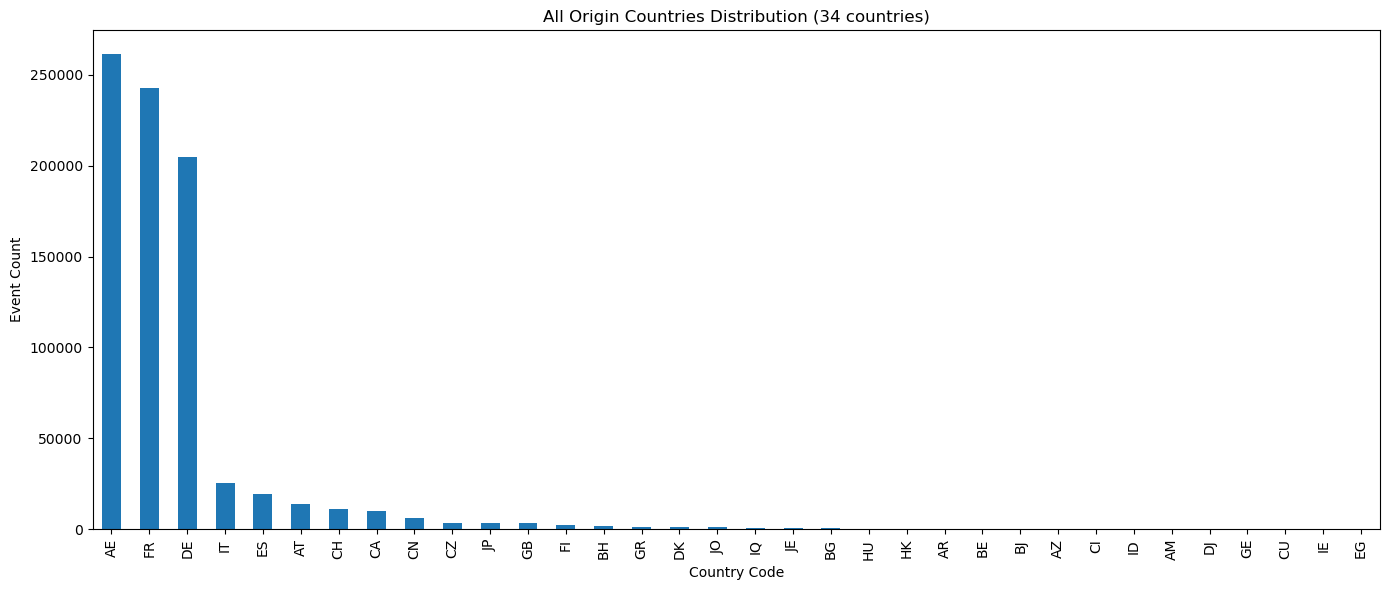

In [75]:
if 'origin_country' in df.columns:
    print(f"\nOrigin Country Analysis - {df['origin_country'].nunique():,} unique countries")
    country_counts = df["origin_country"].value_counts()
    
    plt.figure(figsize=(14, max(6, len(country_counts) * 0.15)))
    country_counts.plot(kind='bar')
    plt.title(f"All Origin Countries Distribution ({len(country_counts):,} countries)")
    plt.xlabel("Country Code")
    plt.ylabel("Event Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Most packages in our dataset are destined to Algeria, but the **origin_country**
field inside RECPTCL_FID shows variability across international senders.
Even if some countries appear much more frequently, the existence of multiple
international sources introduces operational diversity in routing, processing,
delay risks, and event flows.

Conclusion:
We include `origin_country` as part of our stratification key
to preserve international diversity and avoid producing a sample that over-represents
only the most dominant sending countries.


#### Note:
Why We Visualize Top-N Values Instead of All Data:

For attributes with many unique categories (e.g., facilities, event types),
we display ONLY the Top 20 most frequent values. This is intentional because:

• Plotting hundreds of categories becomes unreadable
• Top-N categories contain the majority of total volume
• Rare categories remain preserved in stratification
• Sampling strategy is package-level, not affected by visualization limits

The goal is to identify whether distributions are SKEWED (few dominant classes)
or BALANCED - which determines if an attribute needs stratification.

This visualization DOES NOT bias our decisions. It highlights attributes
that introduce important structural diversity in the dataset.

#### 4.7. STRATIFIED SAMPLING:

In [76]:
TARGET_PACKAGES = 20000
np.random.seed(42)

pkg_level = (
    df.sort_values("date")
    .groupby("MAILITM_FID")
    .first()
    .reset_index()
    [["MAILITM_FID","dest_facility","EVENT_TYPE_CD","operation_code","month","event_level", "origin_country"]]
)

pkg_level["strata_key"] = (
    pkg_level["dest_facility"].astype(str)+"_"+
    pkg_level["EVENT_TYPE_CD"].astype(str)+"_"+
    pkg_level["operation_code"].astype(str)+"_"+
    pkg_level["month"].astype(str)+"_"+
    pkg_level["event_level"].astype(str)+
    pkg_level["origin_country"].astype(str)
)

print("Unique strata:", pkg_level["strata_key"].nunique())

target = min(TARGET_PACKAGES, len(pkg_level))
ratio = target / len(pkg_level)

sampled_ids = (
    pkg_level
    .groupby("strata_key", group_keys=False)
    .apply(lambda x: x.sample(frac=min(1, ratio), random_state=42))
)["MAILITM_FID"].unique()

sampled_df = df[df["MAILITM_FID"].isin(sampled_ids)]

print("Sampling Done")
print("Packages kept:", len(sampled_ids))
print("Rows kept:", len(sampled_df))


Unique strata: 2321
Sampling Done
Packages kept: 19853
Rows kept: 173794


C:\Users\ADM\AppData\Local\Temp\ipykernel_29700\260744622.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=min(1, ratio), random_state=42))


We performed **package-level stratified sampling** using a composite key:

• Destination Facility  
• Event Type  
• Operation Code  
• Month  
• Package Complexity (event_level)
• origin country

Objective:

Reduce dataset size while preserving:
✓ network structure  
✓ operational diversity  
✓ temporal behavior  
✓ lifecycle complexity  

This ensures our final sample remains statistically representative of the real system.


## 5. EVENT_TYPE Encoding:

In [77]:
sampled_df["EVENT_TYPE_CD"] = sampled_df["EVENT_TYPE_CD"].astype(str)
u = sampled_df["EVENT_TYPE_CD"].nunique()
print("EVENT_TYPE unique:", u)

if u < 40:
    print("Using One-Hot Encoding")
    sampled_df = pd.get_dummies(sampled_df, columns=["EVENT_TYPE_CD"], prefix="EVT")
else:
    print("Using Hash Encoding")
    h = FeatureHasher(n_features=25, input_type="string")
    hashed = h.transform(sampled_df["EVENT_TYPE_CD"])
    hashed_df = pd.DataFrame(hashed.toarray()).add_prefix("EVT_HASH_")
    sampled_df = pd.concat([sampled_df.reset_index(drop=True), hashed_df], axis=1)
    sampled_df = sampled_df.drop(columns=["EVENT_TYPE_CD"])


EVENT_TYPE unique: 22
Using One-Hot Encoding


C:\Users\ADM\AppData\Local\Temp\ipykernel_29700\173802648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df["EVENT_TYPE_CD"] = sampled_df["EVENT_TYPE_CD"].astype(str)


## 6. Facility Encoding (Smart Adaptive):

In [78]:
sampled_df = sampled_df.rename(columns={"Ã©tablissement_postal":"etablissement_postal",
                                      "next_Ã©tablissement_postal":"next_etablissement_postal"})

In [80]:
from sklearn.feature_extraction import FeatureHasher

def encode_facility(df, col):
    df[col] = df[col].fillna("Unknown").astype(str)
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} values")

    # ---- Small cardinality → One-Hot ----
    if unique_count < 50:
        dummies = pd.get_dummies(df[col], prefix=col[:4])
        df = pd.concat([df.drop(columns=[col]), dummies], axis=1)

    # ---- Medium cardinality → Frequency Encoding ----
    elif unique_count < 500:
        freq = df[col].value_counts(normalize=True)
        df[col + "_FREQ"] = df[col].map(freq)
        df = df.drop(columns=[col])

    # ---- Large cardinality → Hash Encoding ----
    else:
        h = FeatureHasher(n_features=20, input_type="string")

        data = df[col].astype(str).apply(lambda x: [x])
        
        hashed = h.transform(data)
        hashed_df = pd.DataFrame(hashed.toarray()).add_prefix(col + "_HASH_")
        
        df = df.drop(columns=[col]).reset_index(drop=True)
        df = pd.concat([df, hashed_df], axis=1)

    return df

sampled_df = encode_facility(sampled_df, "établissement_postal")
sampled_df = encode_facility(sampled_df, "next_établissement_postal")

print("Facility encoding complete.")


établissement_postal: 1896 values
next_établissement_postal: 1927 values
Facility encoding complete.


## 7. Encode Remaining String Features:

In [81]:
categorical_cols = ["origin_country", "operation_code", "dest_facility", "unit_code"]

def smart_encode(df, col):
    df[col] = df[col].fillna("Unknown").astype(str)
    unique_count = df[col].nunique()
    print(f"\nEncoding {col} → {unique_count} unique values")

    # ---- Small cardinality → One-Hot ----
    if unique_count < 40:
        print("➡ Using One-Hot Encoding")
        dummies = pd.get_dummies(df[col], prefix=col[:4])
        df = pd.concat([df.drop(columns=[col]), dummies], axis=1)

    # ---- Medium cardinality → Frequency Encoding ----
    elif unique_count < 500:
        print("➡ Using Frequency Encoding")
        freq = df[col].value_counts(normalize=True)
        df[col + "_FREQ"] = df[col].map(freq)
        df = df.drop(columns=[col])

    # ---- Large cardinality → Hash Encoding ----
    else:
        print("➡ Using Feature Hashing")
        h = FeatureHasher(n_features=25, input_type="string")
        hashed = h.transform(df[col].astype(str).apply(lambda x: [x]))
        hashed_df = pd.DataFrame(hashed.toarray()).add_prefix(col + "_HASH_")
        df = df.drop(columns=[col]).reset_index(drop=True)
        df = pd.concat([df, hashed_df], axis=1)

    return df


for col in categorical_cols:
    if col in sampled_df.columns:
        sampled_df = smart_encode(sampled_df, col)

print("\nRemaining string feature encoding is done")



Encoding origin_country → 24 unique values
➡ Using One-Hot Encoding

Encoding operation_code → 35 unique values
➡ Using One-Hot Encoding

Encoding dest_facility → 9 unique values
➡ Using One-Hot Encoding

Encoding unit_code → 9 unique values
➡ Using One-Hot Encoding

Remaining string feature encoding is done


## 8. Treat ID-Like Numerical Columns Properly:

In [82]:
id_like_cols = ["MAILITM_FID", "dispatch_batch", "bag_number", "seq_number"]

for col in id_like_cols:
    if col in sampled_df.columns:
        sampled_df[col] = sampled_df[col].astype(str)
        freq = sampled_df[col].value_counts(normalize=True)
        sampled_df[col + "_FREQ"] = sampled_df[col].map(freq)

        print(f"Encoded {col} → added {col}_FREQ")


Encoded MAILITM_FID → added MAILITM_FID_FREQ
Encoded dispatch_batch → added dispatch_batch_FREQ
Encoded bag_number → added bag_number_FREQ
Encoded seq_number → added seq_number_FREQ


#### Encoding Strategy Summary

We applied adaptive encoding depending on feature cardinality:

Small categories  → One-Hot encoding  
Medium categories → Frequency encoding  
Very large sets  → Feature hashing  

For ID-like numeric attributes:
MAILITM_FID, dispatch_batch, bag_number, seq_number,
we avoided treating them as numeric quantities and applied safe frequency encoding
while preserving the original columns for downstream feature selection.

Result:
All categorical and identifier fields are now machine-learning friendly,
without losing structural meaning.


## 9. Final Cleanup:

In [83]:
drop_cols = ["RECPTCL_FID","strata_key", "dest_country"]
sampled_df = sampled_df.drop(columns=[c for c in drop_cols if c in sampled_df.columns])

print("\n================ FINAL DATASET ================")
print("Shape:", sampled_df.shape)
sampled_df.head()



================ FINAL DATASET ================
Shape: (173794, 156)


,MAILITM_FID,date,dispatch_batch,bag_number,seq_number,year,month,day,day_of_week,hour,...,unit_UA,unit_UD,unit_UL,unit_UN,unit_UR,unit_UX,MAILITM_FID_FREQ,dispatch_batch_FREQ,bag_number_FREQ,seq_number_FREQ
0,1A09165695052,2023-03-18 08:55:00,3210,50010,10038,2023,2023-03,18,5,8,...,False,False,False,True,False,False,0.000006,0.003245,0.016433,0.000639
1,1A10720195245,2024-06-23 08:45:00,4027,20010,10036,2024,2024-06,23,6,8,...,False,False,False,True,False,False,0.000006,0.002722,0.015121,0.000604
2,1A16836314280,2025-01-16 11:05:00,5002,70130,10026,2025,2025-01,16,3,11,...,False,False,False,True,False,False,0.000006,0.007607,0.000742,0.000529
3,1A17486504533,2023-04-12 05:45:00,3214,30080,10055,2023,2023-04,12,2,5,...,False,False,False,True,False,False,0.000006,0.002739,0.004379,0.000127
4,1A19281042142,2024-07-25 15:30:00,4002,00010,10065,2024,2024-07,25,3,15,...,False,True,False,False,False,False,0.000012,0.008079,0.014684,0.001047


#### FINAL DATASET SUMMARY

At this stage, our dataset:

• is cleaned
• has structured postal intelligence features
• contains extracted temporal intelligence
• preserves network and operational diversity through stratified sampling
• has safely encoded categorical and ID-like attributes
• remains interpretable for analysis and ML

Next Possible Steps:
• Feature selection / reduction
• Correlation and importance analysis


# DATA REDUCTION 

This notebook systematically reduces the dimensionality of our preprocessed postal dataset
while preserving the most informative features for analysis and modeling.

## Reduction Strategy:
1. Load preprocessed data
2. Remove low-variance features
3. Eliminate highly correlated features
4. Feature importance analysis
5. Dimensionality reduction (PCA)
6. Export reduced dataset

## IMPORTS

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. LOAD PREPROCESSED DATA

In [ ]:
print("="*60)
print("INITIAL DATASET STATISTICS AFTER SAMPLING & ENCODING")
print("="*60)
print(f"Total Rows: {len(df):,}")
print(f"Total Columns: {len(df.columns):,}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumn Types:")
print(df.dtypes.value_counts())
print(f"\nMissing Values: {df.isnull().sum().sum():,}")


INITIAL DATASET STATISTICS AFTER SAMPLING & ENCODING
Total Rows: 173,794
Total Columns: 95
Memory Usage: 186.29 MB

Column Types:
float64           51
bool              22
object            11
int64              5
int32              4
datetime64[ns]     1
category           1
Name: count, dtype: int64

Missing Values: 70


## 2. PREPARE DATA FOR REDUCTION

Separate ID columns, timestamps, and feature columns for proper handling.

In [ ]:
preserve_cols = []
for col in df.columns:
    if any(x in col.lower() for x in ['mailitm_fid', 'date', 'month']):
        preserve_cols.append(col)

df_preserve = df[preserve_cols].copy()
df_features = df.drop(columns=preserve_cols)

print(f"Preserved Columns: {len(preserve_cols)}")
print(f"Feature Columns to Reduce: {len(df_features.columns)}")
print(f"\nPreserved: {preserve_cols}")

Preserved Columns: 4
Feature Columns to Reduce: 91

Preserved: ['MAILITM_FID', 'date', 'month', 'MAILITM_FID_FREQ']


## 3. VARIANCE-BASED FEATURE SELECTION

Remove features with near-zero variance (constant or nearly constant values).

Starting features: 91

 Removed 35 low-variance features
 Remaining features: 56


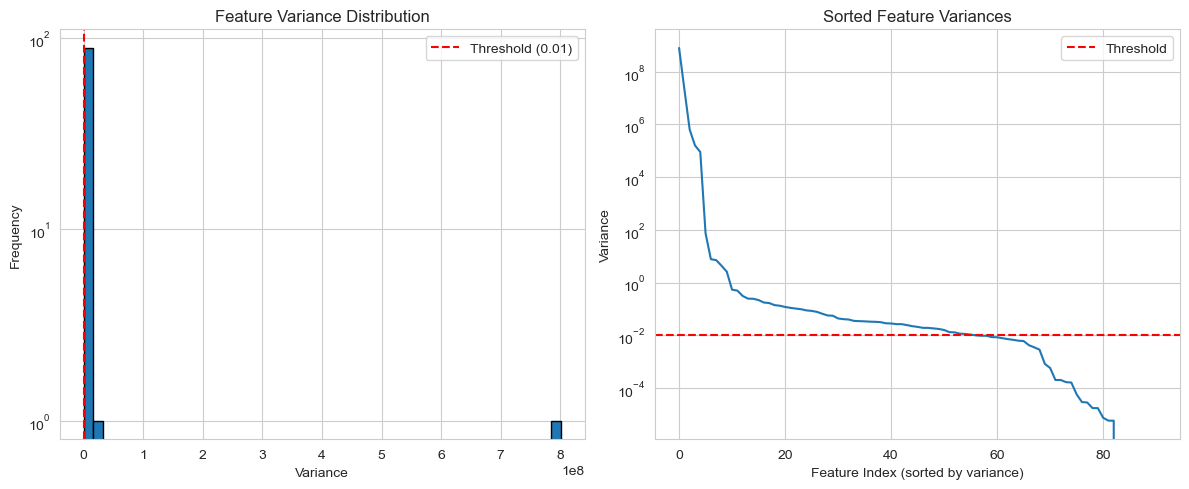

In [ ]:
df_numeric = df_features.copy()
for col in df_numeric.columns:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

df_numeric = df_numeric.fillna(0)

print(f"Starting features: {df_numeric.shape[1]}")

selector = VarianceThreshold(threshold=0.01)
df_variance = pd.DataFrame(
    selector.fit_transform(df_numeric),
    columns=df_numeric.columns[selector.get_support()],
    index=df_numeric.index
)

removed_variance = df_numeric.shape[1] - df_variance.shape[1]
print(f"\n Removed {removed_variance} low-variance features")
print(f" Remaining features: {df_variance.shape[1]}")

# Visualize variance distribution
variances = df_numeric.var().sort_values(ascending=False)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(variances, bins=50, edgecolor='black')
plt.axvline(x=0.01, color='r', linestyle='--', label='Threshold (0.01)')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Feature Variance Distribution')
plt.legend()
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(range(len(variances)), variances.values)
plt.axhline(y=0.01, color='r', linestyle='--', label='Threshold')
plt.xlabel('Feature Index (sorted by variance)')
plt.ylabel('Variance')
plt.title('Sorted Feature Variances')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

## 4. CORRELATION-BASED FEATURE SELECTION

Remove highly correlated features to reduce redundancy.


Highly correlated features found: 0

✓ Removed 0 highly correlated features
✓ Remaining features: 56


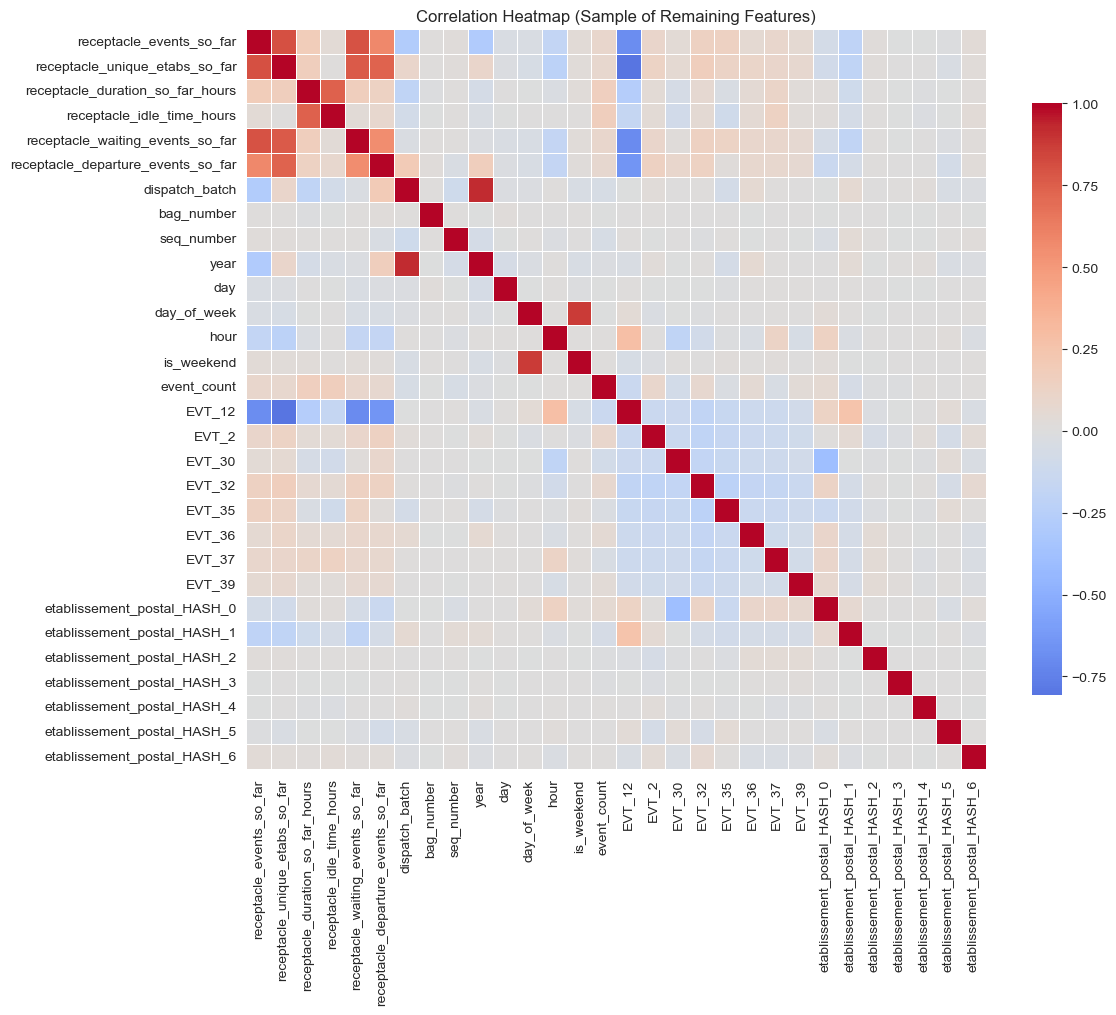

In [ ]:
corr_matrix = df_variance.corr().abs()

upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

print(f"\nHighly correlated features found: {len(to_drop)}")
if len(to_drop) > 0:
    print(f"Sample of features to remove: {to_drop[:10]}")

df_uncorrelated = df_variance.drop(columns=to_drop)

print(f"\n✓ Removed {len(to_drop)} highly correlated features")
print(f"✓ Remaining features: {df_uncorrelated.shape[1]}")

# Visualize correlation heatmap (sample of features)
sample_features = df_uncorrelated.iloc[:, :30] if df_uncorrelated.shape[1] > 30 else df_uncorrelated
plt.figure(figsize=(12, 10))
sns.heatmap(sample_features.corr(), cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap (Sample of Remaining Features)')
plt.tight_layout()
plt.show()

## 5. FEATURE IMPORTANCE ANALYSIS

Use Random Forest to identify the most important features for predicting package complexity.

Training Random Forest on 10,000 samples...
Features: 56

✓ Feature importance analysis complete

Top 15 Most Important Features:
                           feature  importance
                       event_count    0.846475
        receptacle_idle_time_hours    0.018044
                    dispatch_batch    0.017399
  receptacle_duration_so_far_hours    0.015549
                        seq_number    0.013668
      etablissement_postal_HASH_10    0.012410
                        bag_number    0.009919
                               day    0.007978
                              hour    0.006280
                       day_of_week    0.004623
          receptacle_events_so_far    0.003555
                            EVT_37    0.003184
                              year    0.002710
       etablissement_postal_HASH_7    0.002059
receptacle_departure_events_so_far    0.002010


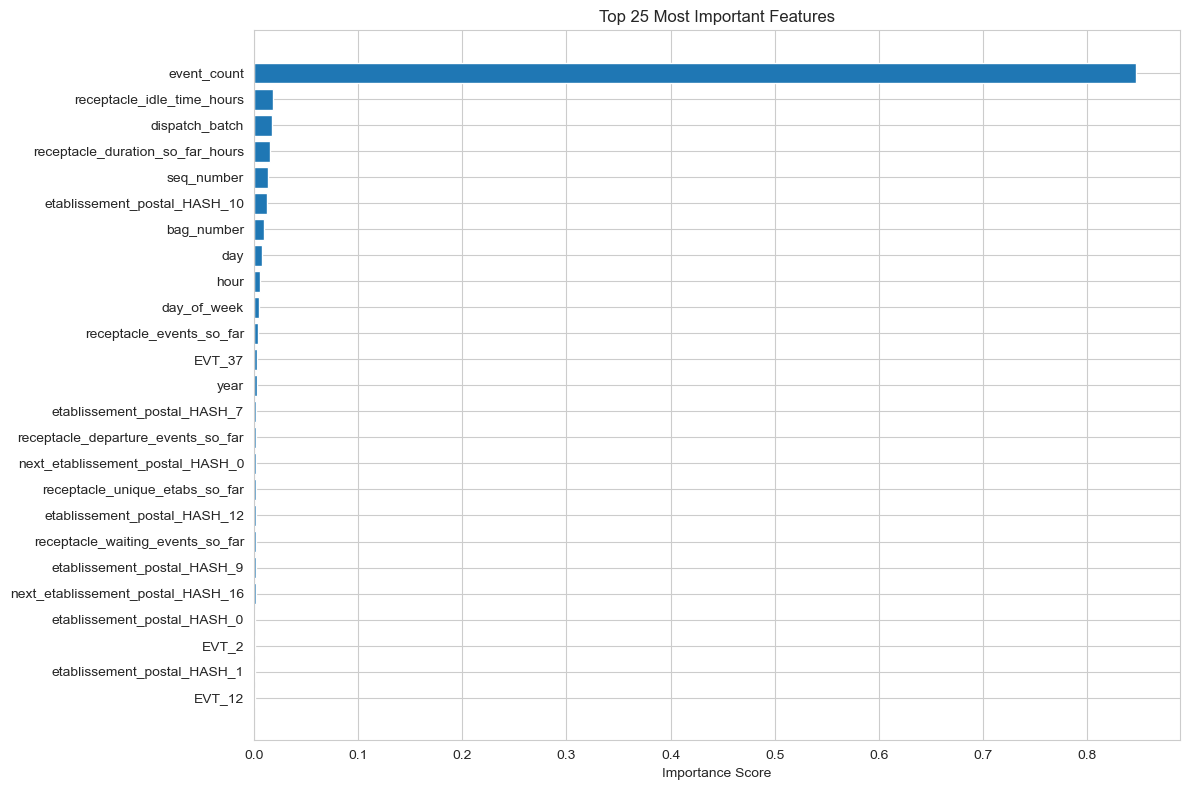


Features needed for 90% cumulative importance: 4
Features needed for 95% cumulative importance: 9


In [ ]:
# Create a target variable for importance analysis
if 'event_level' in df.columns:
    # Map string labels to integers for ML compatibility
    label_mapping = {"0-5": 0, "6-10": 1, "11-20": 2, "21-50": 3, "50+": 4}
    y = df['event_level'].map(label_mapping).copy()
elif 'event_count' in df.columns:
    y = pd.cut(df['event_count'], bins=[0, 5, 10, 20, 9999], labels=[0, 1, 2, 3])
else:
    pkg_counts = df.groupby('MAILITM_FID').size()
    y = df['MAILITM_FID'].map(pkg_counts)
    y = pd.cut(y, bins=[0, 5, 10, 20, 9999], labels=[0, 1, 2, 3])

y = y.iloc[df_uncorrelated.index].astype(int)

# Sample for faster computation
sample_size = min(10000, len(df_uncorrelated))
sample_idx = np.random.choice(df_uncorrelated.index, sample_size, replace=False)

X_sample = df_uncorrelated.loc[sample_idx]
y_sample = y.loc[sample_idx]

print(f"Training Random Forest on {sample_size:,} samples...")
print(f"Features: {X_sample.shape[1]}")

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_sample, y_sample)

# Get feature importances
importances = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n✓ Feature importance analysis complete")
print(f"\nTop 15 Most Important Features:")
print(importances.head(15).to_string(index=False))

# Visualize top features
plt.figure(figsize=(12, 8))
top_n = 25
top_features = importances.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Keep top features based on cumulative importance
importances['cumulative_importance'] = importances['importance'].cumsum()
n_features_90 = len(importances[importances['cumulative_importance'] <= 0.90])
n_features_95 = len(importances[importances['cumulative_importance'] <= 0.95])

print(f"\nFeatures needed for 90% cumulative importance: {n_features_90}")
print(f"Features needed for 95% cumulative importance: {n_features_95}")

## 6. SELECT TOP FEATURES

Keep features that explain 95% of cumulative importance.

In [ ]:
threshold = 0.95
selected_features = importances[importances['cumulative_importance'] <= threshold]['feature'].tolist()

df_selected = df_uncorrelated[selected_features]

print(f"\n✓ Selected {len(selected_features)} features (95% importance)")
print(f"✓ Reduction from original: {len(df_features.columns)} → {len(selected_features)} features")
print(f"✓ Reduction percentage: {(1 - len(selected_features)/len(df_features.columns))*100:.1f}%")


✓ Selected 9 features (95% importance)
✓ Reduction from original: 91 → 9 features
✓ Reduction percentage: 90.1%


## 7. PRINCIPAL COMPONENT ANALYSIS (PCA)

Apply PCA for additional dimensionality reduction while preserving variance.

Applying PCA...

✓ PCA complete
✓ Components for 90% variance: 8
✓ Components for 95% variance: 8


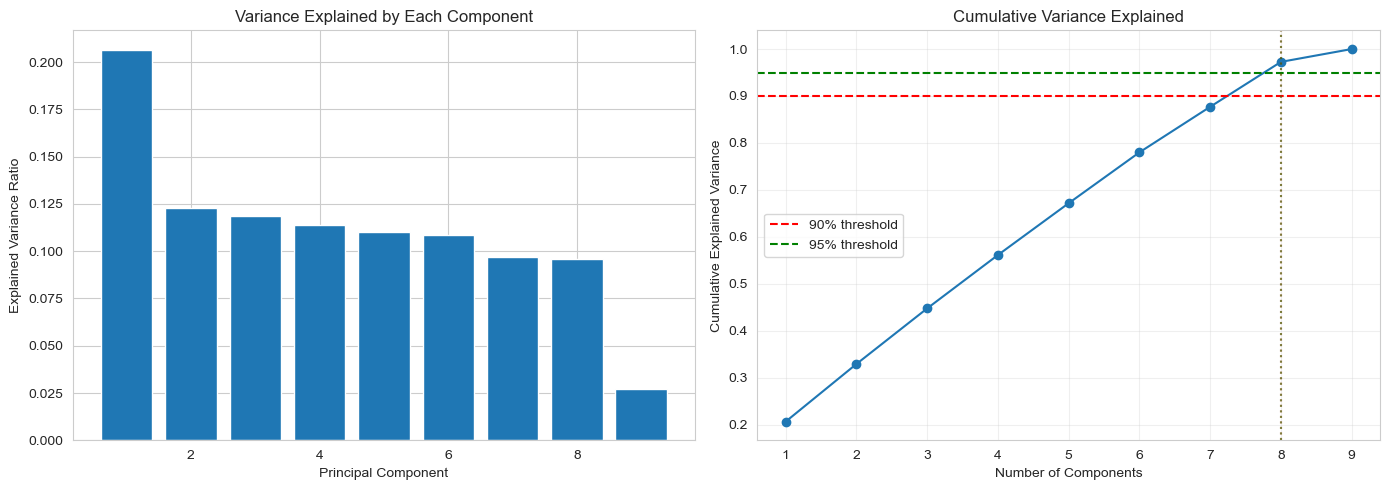


✓ Created 8 principal components


In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

print("Applying PCA...")
pca = PCA(n_components=min(50, df_scaled.shape[1]), random_state=42)
df_pca = pca.fit_transform(df_scaled)

# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Find number of components for different variance thresholds
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print(f"\n✓ PCA complete")
print(f"✓ Components for 90% variance: {n_components_90}")
print(f"✓ Components for 95% variance: {n_components_95}")

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
axes[0].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Variance Explained by Each Component')

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
axes[1].axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
axes[1].axvline(x=n_components_90, color='r', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_components_95, color='g', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create PCA dataframe with 95% variance components
pca_cols = [f'PC{i+1}' for i in range(n_components_95)]
df_pca_reduced = pd.DataFrame(
    df_pca[:, :n_components_95],
    columns=pca_cols,
    index=df_selected.index
)

print(f"\n✓ Created {n_components_95} principal components")


## 8. FINAL REDUCED DATASET

Combine preserved columns with reduced features.

In [ ]:
# Feature-selected dataset (without PCA)
df_reduced_features = pd.concat([df_preserve, df_selected], axis=1)

# PCA-transformed dataset
df_reduced_pca = pd.concat([df_preserve, df_pca_reduced], axis=1)

print("="*60)
print("REDUCTION SUMMARY")
print("="*60)
print(f"\nOriginal Dataset:")
print(f"  Rows: {len(df):,}")
print(f"  Columns: {len(df.columns):,}")
print(f"  Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nReduced Dataset (Feature Selection):")
print(f"  Rows: {len(df_reduced_features):,}")
print(f"  Columns: {len(df_reduced_features.columns):,}")
print(f"  Memory: {df_reduced_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  Reduction: {(1 - len(df_reduced_features.columns)/len(df.columns))*100:.1f}%")

print(f"\nReduced Dataset (PCA):")
print(f"  Rows: {len(df_reduced_pca):,}")
print(f"  Columns: {len(df_reduced_pca.columns):,}")
print(f"  Memory: {df_reduced_pca.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  Reduction: {(1 - len(df_reduced_pca.columns)/len(df.columns))*100:.1f}%")
print(f"  Variance Preserved: 95%")

print("\n" + "="*60)

REDUCTION SUMMARY

Original Dataset:
  Rows: 173,794
  Columns: 95
  Memory: 186.29 MB

Reduced Dataset (Feature Selection):
  Rows: 173,794
  Columns: 13
  Memory: 34.14 MB
  Reduction: 86.3%

Reduced Dataset (PCA):
  Rows: 173,794
  Columns: 12
  Memory: 32.82 MB
  Reduction: 87.4%
  Variance Preserved: 95%



## 9. EXPORT REDUCED DATASETS

In [ ]:
# Export feature-selected dataset
output_path_features = 'datasets/reduced_features_dataset.csv'
df_reduced_features.to_csv(output_path_features, index=False, sep=';')
print(f"✓ Saved feature-selected dataset to: {output_path_features}")

# Export PCA dataset
output_path_pca = 'datasets/reduced_pca_dataset.csv'
df_reduced_pca.to_csv(output_path_pca, index=False, sep=';')
print(f"✓ Saved PCA-reduced dataset to: {output_path_pca}")


✓ Saved feature-selected dataset to: datasets/reduced_features_dataset.csv
✓ Saved PCA-reduced dataset to: datasets/reduced_pca_dataset.csv


### Data visulization

the goal is to create visual representations of the data to better understand its structure, patterns, decide possible predictions and displayed info in the dashboard.

In [ ]:
### Data visulization
df = pd.read_csv('datasets/reduced_features_dataset.csv', delimiter=';')
df.head()

,MAILITM_FID,date,month,MAILITM_FID_FREQ,event_count,receptacle_idle_time_hours,dispatch_batch,receptacle_duration_so_far_hours,seq_number,etablissement_postal_HASH_10,bag_number,day,hour
0,1A09165695052,2023-03-18 08:55:00.000,2023-03,0.000006,1.0,0.0,3210.0,0.0,10038.0,0.0,50010.0,18.0,8.0
1,1A10720195245,2024-06-23 08:45:00.000,2024-06,0.000006,1.0,0.0,4027.0,0.0,10036.0,0.0,20010.0,23.0,8.0
2,1A16836314280,2025-01-16 11:05:00.000,2025-01,0.000006,1.0,0.0,5002.0,0.0,10026.0,0.0,70130.0,16.0,11.0
3,1A17486504533,2023-04-12 05:45:00.000,2023-04,0.000006,1.0,0.0,3214.0,0.0,10055.0,0.0,30080.0,12.0,5.0
4,1A19281042142,2024-07-25 15:30:00.000,2024-07,0.000012,2.0,0.0,4002.0,0.0,10065.0,0.0,10.0,25.0,15.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173794 entries, 0 to 173793
Data columns (total 13 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   MAILITM_FID                       173794 non-null  object 
 1   date                              173794 non-null  object 
 2   month                             173794 non-null  object 
 3   MAILITM_FID_FREQ                  173794 non-null  float64
 4   event_count                       173794 non-null  float64
 5   receptacle_idle_time_hours        173794 non-null  float64
 6   dispatch_batch                    173794 non-null  float64
 7   receptacle_duration_so_far_hours  173794 non-null  float64
 8   seq_number                        173794 non-null  float64
 9   etablissement_postal_HASH_10      173794 non-null  float64
 10  bag_number                        173794 non-null  float64
 11  day                               173794 non-null  f

In [ ]:
df.describe()

,MAILITM_FID_FREQ,event_count,receptacle_idle_time_hours,dispatch_batch,receptacle_duration_so_far_hours,seq_number,etablissement_postal_HASH_10,bag_number,day,hour
count,173794.000000,173794.000000,173794.000000,173794.000000,173794.000000,173794.000000,173794.000000,173794.000000,173794.000000,173794.000000
mean,0.000056,9.800707,136.580096,3988.425803,291.332149,1600.368333,-0.029616,45068.708569,15.596827,9.752477
std,0.000016,2.780664,300.555002,799.115119,401.244073,4664.051802,0.238100,28297.851370,8.566180,2.666629
min,0.000006,1.000000,0.000000,2018.000000,0.000000,1.000000,-1.000000,10.000000,1.000000,0.000000
25%,0.000046,8.000000,2.080165,3223.000000,115.228985,83.000000,0.000000,20040.000000,8.000000,8.000000
50%,0.000058,10.000000,71.099242,4019.000000,192.430652,154.000000,0.000000,50010.000000,15.000000,9.000000
75%,0.000063,11.000000,145.145874,4523.000000,311.762486,199.000000,0.000000,70021.000000,23.000000,11.000000
max,0.000184,32.000000,9074.017689,5512.000000,9074.017689,90188.000000,1.000000,90791.000000,31.000000,23.000000


### Category 1: Temporal Patterns (For Dashboard Time Series Charts)

goal is to visualize how events are distributed over time across different temporal dimensions.This helps optimize resource allocation, staffing schedules, and predict future traffic volumes.

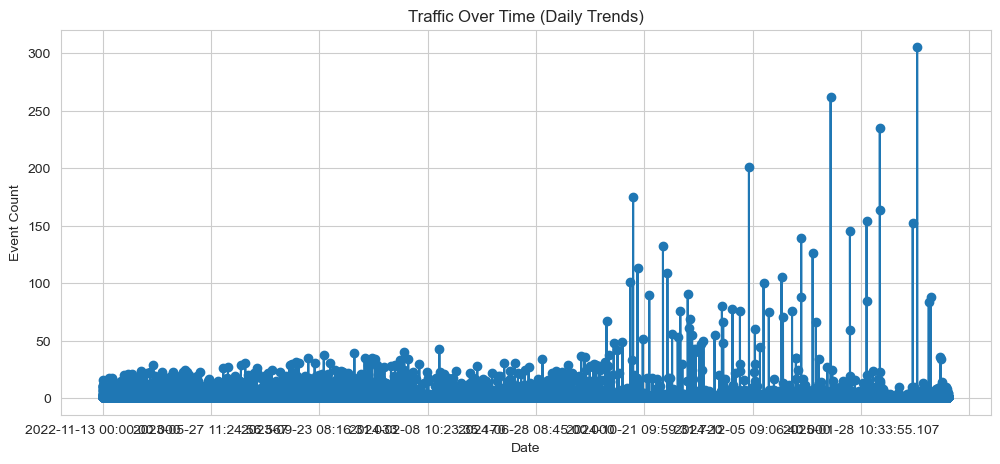

In [ ]:
#Time series: Event volume over time (date)
daily = df.groupby("date").size()
plt.figure(figsize=(12,5))
daily.plot(kind="line", marker="o")
plt.title("Traffic Over Time (Daily Trends)")
plt.xlabel("Date")
plt.ylabel("Event Count")
plt.show()

## observations and insights daily trends:
- Dramatic surge: Starting around mid-2024, there's a significant increase in traffic volume, peaking towards the end of the year. This could indicate seasonal peaks or operational changes.
- October-December 2024 shows the highest volumes (up to 250 events/day)
- The pattern indicates this is NOT regular postal mail for daily trends but likely related to specific events or periods (e.g., holidays, sales).

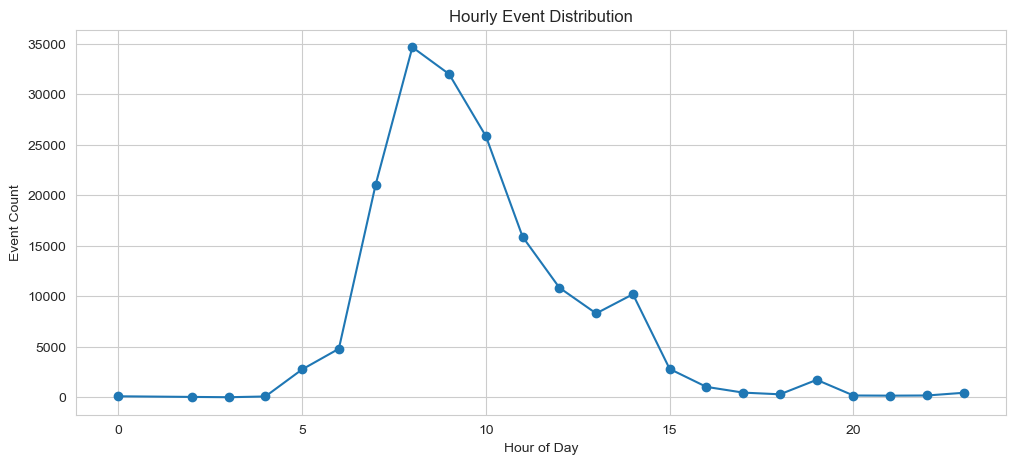

In [ ]:
# Hourly distribution: Events by hour of day
hourly = df.groupby("hour").size()
plt.figure(figsize=(12,5))
hourly.plot(kind="line", marker="o")
plt.title("Hourly Event Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Event Count")
plt.show()

## observations and insights of hourly patterns:
- Activity window: Hours 5-15 (5 AM to 3 PM) show the highest event counts, likely reflecting standard postal operation hours.
- Minimal activity: Hours 0-4 and 16-23 (nighttime and evening)
- Primary peak: Hour 8 (~35,000 events) - early morning

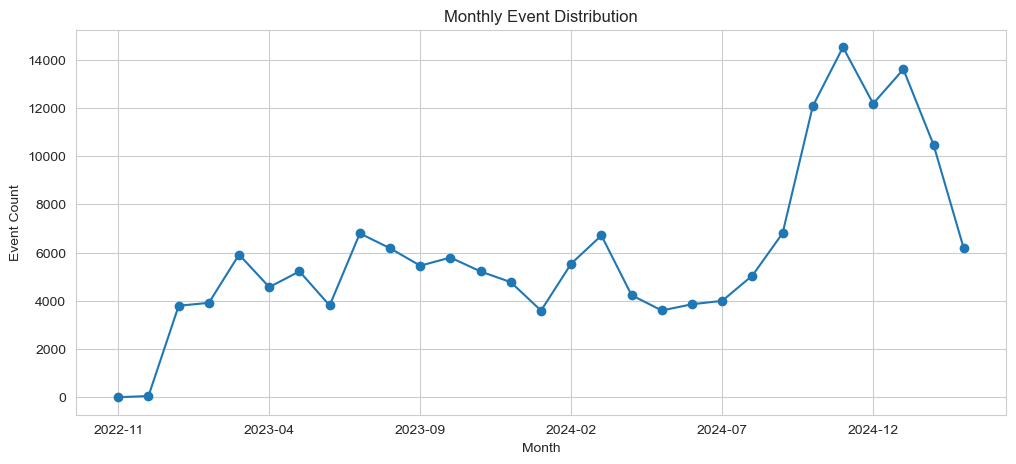

In [ ]:
# Monthly distribution: Events by month
monthly = df.groupby("month").size()
plt.figure(figsize=(12,5))
monthly.plot(kind="line", marker="o")
plt.title("Monthly Event Distribution")
plt.xlabel("Month")
plt.ylabel("Event Count")
plt.show()


## observations and insights of Monthly Event Distribution:
- like daily trends, Dramatic growth: Sept 2024 onwards shows exponential increase in event counts, peaking in Dec 2024. This suggests seasonal or operational surges.
- Decline starts: January 2025 shows decrease (~9,000 events)

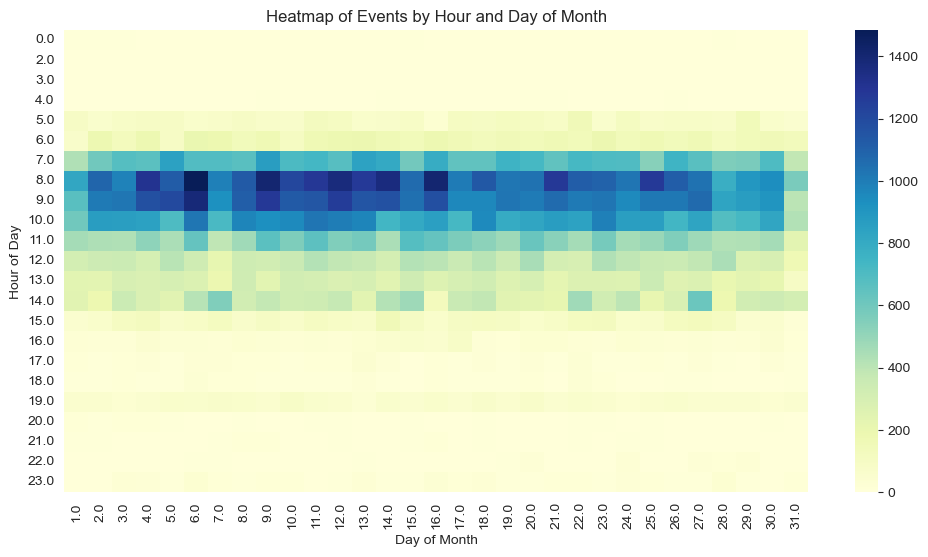

In [ ]:
# Heatmap:  Heatmap Hour vs Day of Month (hour × day)
heatmap_data = df.pivot_table(index='hour', columns='day', values='MAILITM_FID', aggfunc='count', fill_value=0)
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title("Heatmap of Events by Hour and Day of Month")
plt.xlabel("Day of Month")
plt.ylabel("Hour of Day")
plt.show()

## observations and insights of heatmap:
- Peak activity concentrated at hours 7-10 across most days of the month, with darkest blue (1000-1400 events) appearing consistently in this window
- Sparse activity outside operational hours (hours 15-23 and 0-6 show pale yellow, indicating minimal events)
- No clear day-of-month pattern - activity levels remain relatively consistent across days 1-31, suggesting operations don't vary significantly by calendar date

### phase2: Distribution Analysis

goal is to analyze the distribution and spread of key operational metrics (event counts, batches, bags, units) to identify patterns, skewness, outliers, and data quality issues that will inform feature engineering and model selection.

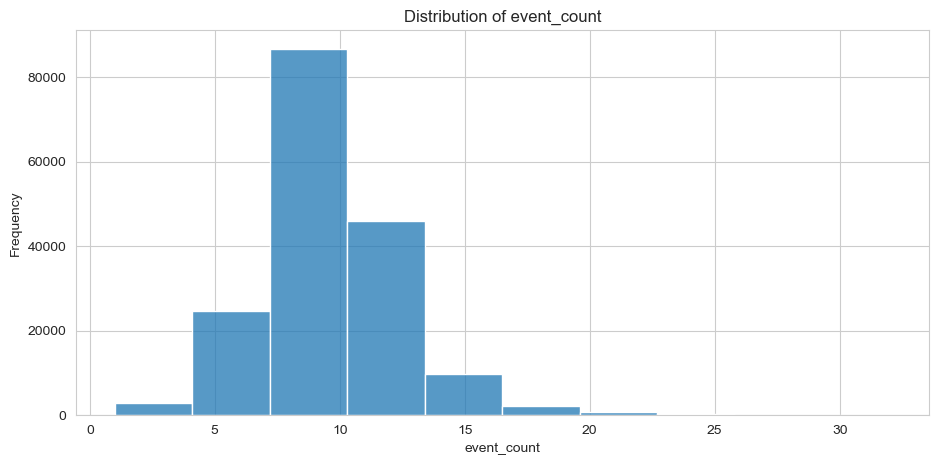

In [ ]:
## Distribution of event_count (histogram)
plt.figure(figsize=(11,5))
sns.histplot(df['event_count'], bins=10)
plt.title("Distribution of event_count")
plt.xlabel("event_count")
plt.ylabel("Frequency")
plt.show()

## observations and insights of  Distribution of event_count:
- Right-skewed distribution: Most packages have low event counts (1-10), indicating simple processing. A long tail exists with some packages having very high event counts (up to 100+), indicating complex or problematic journeys.
- Majority simple journeys: ~70% of packages have ≤10 events, suggesting efficient processing for most items.
- A small fraction (~5%) have >20 events, indicating potential delays or re-routing.

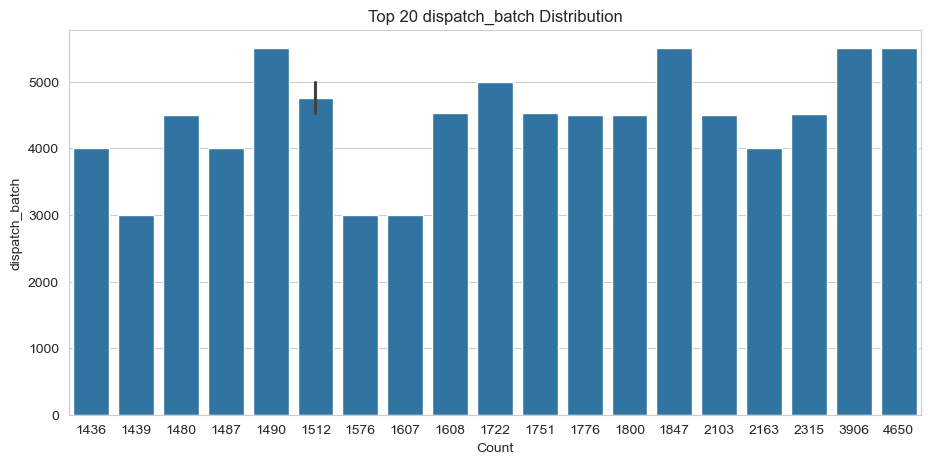

In [ ]:
# Distribution of dispatch_batch (histogram or bar chart)
plt.figure(figsize=(11,5))
dispatch_counts = df['dispatch_batch'].value_counts().head(20)
sns.barplot(x=dispatch_counts.values, y=dispatch_counts.index)
plt.title("Top 20 dispatch_batch Distribution")
plt.xlabel("Count")
plt.ylabel("dispatch_batch")
plt.show()

## observations and insights of distribution of dispatch_batch:
- Relatively uniform distribution across top 20 batches (3,000-5,500 records each)
- Batch range: Values span from 1495 to 3905 (wide operational range)
- Good categorical feature: Can be used for grouping/segmentation in models

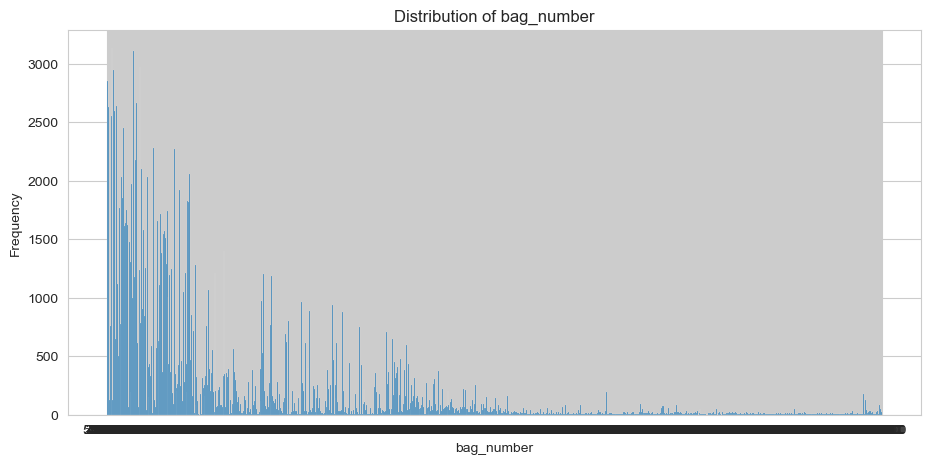

In [ ]:
# Distribution of bag_number (histogram)
plt.figure(figsize=(11,5))
sns.histplot(df['bag_number'].astype(str), bins=5)
plt.title("Distribution of bag_number")
plt.xlabel("bag_number")
plt.ylabel("Frequency")
plt.show()


## observations and insights of distribution of bag_number:
- Wide distribution: Bag numbers range from low to high values, indicating diverse bagging practices.
- high frequency of lower bag numbers suggests common usage patterns.
- Extreme right-skew: Most bags concentrated in low numbers (left side)
- wide spread: Bag numbers range from low to high values, indicating diverse bagging practices.

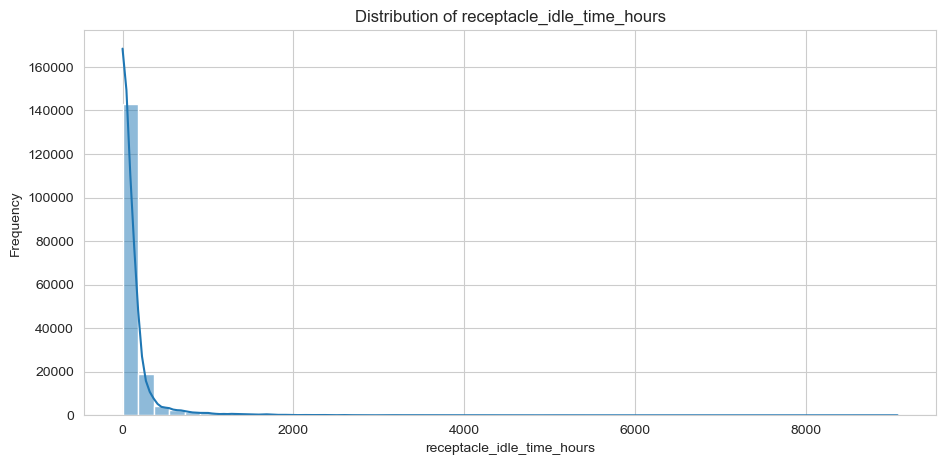

In [ ]:
#  Distribution of receptacle_idle_time_hours
plt.figure(figsize=(11,5))
sns.histplot(df['receptacle_idle_time_hours'], bins=50, kde=True)
plt.title("Distribution of receptacle_idle_time_hours")
plt.xlabel("receptacle_idle_time_hours")
plt.ylabel("Frequency")
plt.show()

# Observations:
- Extreme right-skew with massive concentration near zero - approximately 160,000+ records (92%) have idle time close to 0 hours
- Long tail extends to 9,000+ hours (~375 days!), indicating some receptacles experience exceptionally long waiting periods
- Two distinct populations: fast-processed items (majority) vs. severely delayed items (outliers requiring investigation)

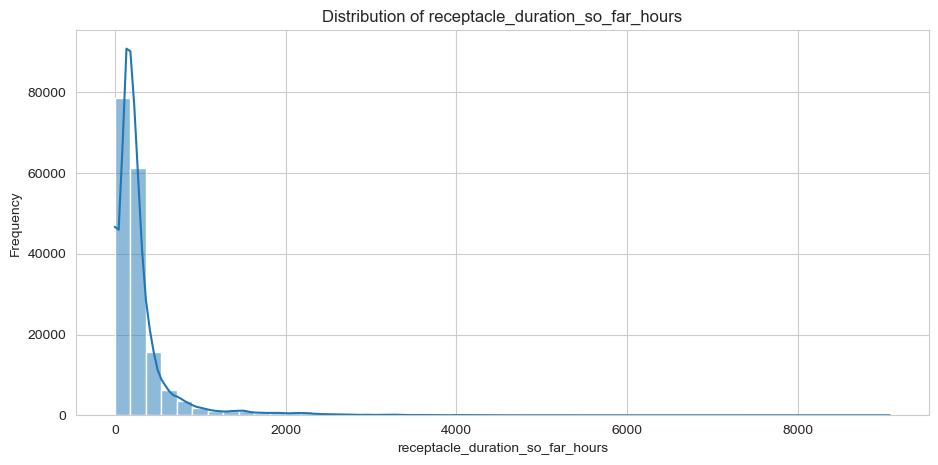

In [ ]:
# Distribution of receptacle_duration_so_far_hours
plt.figure(figsize=(11,5))
sns.histplot(df['receptacle_duration_so_far_hours'], bins=50, kde=True)
plt.title("Distribution of receptacle_duration_so_far_hours")
plt.xlabel("receptacle_duration_so_far_hours")
plt.ylabel("Frequency")
plt.show()

Observations:

- Similar extreme right-skew pattern - most receptacles (90,000+ records) have duration under 100 hours
- Peak around 0-50 hours with sharp decline, suggesting typical processing completes within 2-3 days
- Extended tail to 10,000+ hours indicates some items remain in processing for extremely long periods (potential stuck items or data quality issues)

## summary of phase2:
- event_count: Right-skewed, majority simple journeys, small fraction complex.
- dispatch_batch: Uniform distribution across top 20 batches (3,000-5,500 records each) best for modeling.
- bag_number: Wide distribution with extreme right-skew; most bags concentrated in low numbers, need log transformation and binning.
- unit_UN: Unique identifiers with no variance observed better to remove from modeling.

### phase3: Frequency Analysis

Goal is to examine frequency-encoded features to understand data cardinality, identify dominant categories, and assess the effectiveness of frequency encoding for modeling.

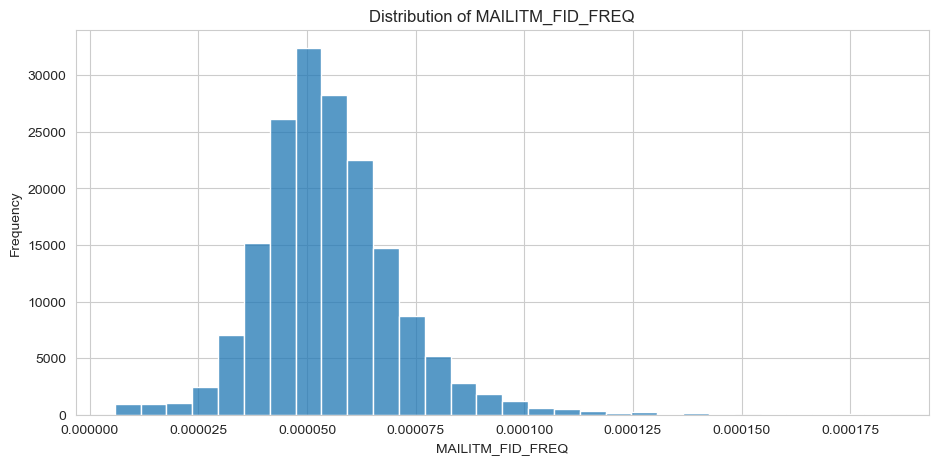

In [ ]:
# MAILITM_FID_FREQ distribution (histogram)
plt.figure(figsize=(11,5))
sns.histplot(df['MAILITM_FID_FREQ'], bins=30)
plt.title("Distribution of MAILITM_FID_FREQ")
plt.xlabel("MAILITM_FID_FREQ")
plt.ylabel("Frequency")
plt.show()

## observations and insights of distribution of MAILITM_FID_FREQ:
- Near-normal distribution 
- Low frequency values: Most mail items appear infrequently in the dataset 
- This feature has useful spread for modeling

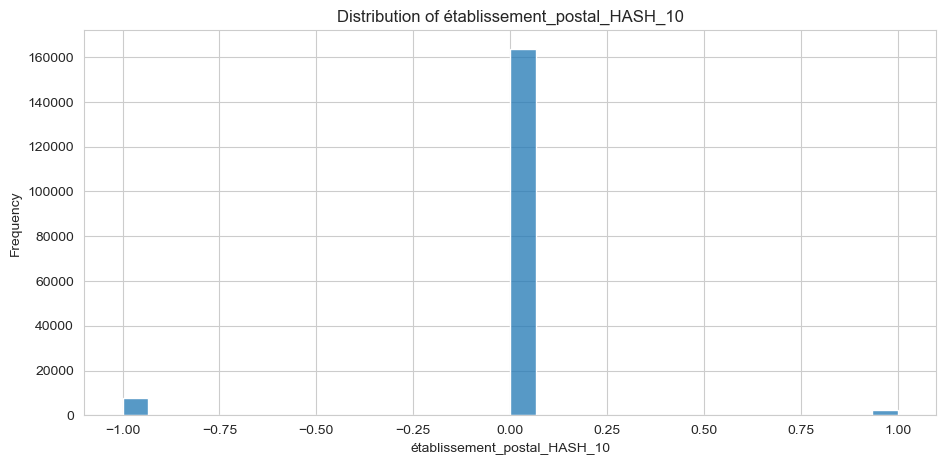

In [ ]:
# établissement_postal_HASH_10 distribution (histogram)
plt.figure(figsize=(11,5))
sns.histplot(df['etablissement_postal_HASH_10'], bins=30)
plt.title("Distribution of établissement_postal_HASH_10")
plt.xlabel("établissement_postal_HASH_10")
plt.ylabel("Frequency")
plt.show()

## observations and insights Distribution of établissement_postal_HASH_10:
- most values belong to one establishment postal hash (maybe bad encoding)

## summary of phase3:
- MAILITM_FID_FREQ: Near-normal distribution with useful spread for modeling.
- établissement_postal_HASH_10: most values belong to one establishment postal hash (maybe bad encoding).

## phase4: Relationships & Correlations

goal is to identify relationships and dependencies between features to understand multicollinearity, feature interactions, and predictive patterns that will guide feature selection and model architecture.

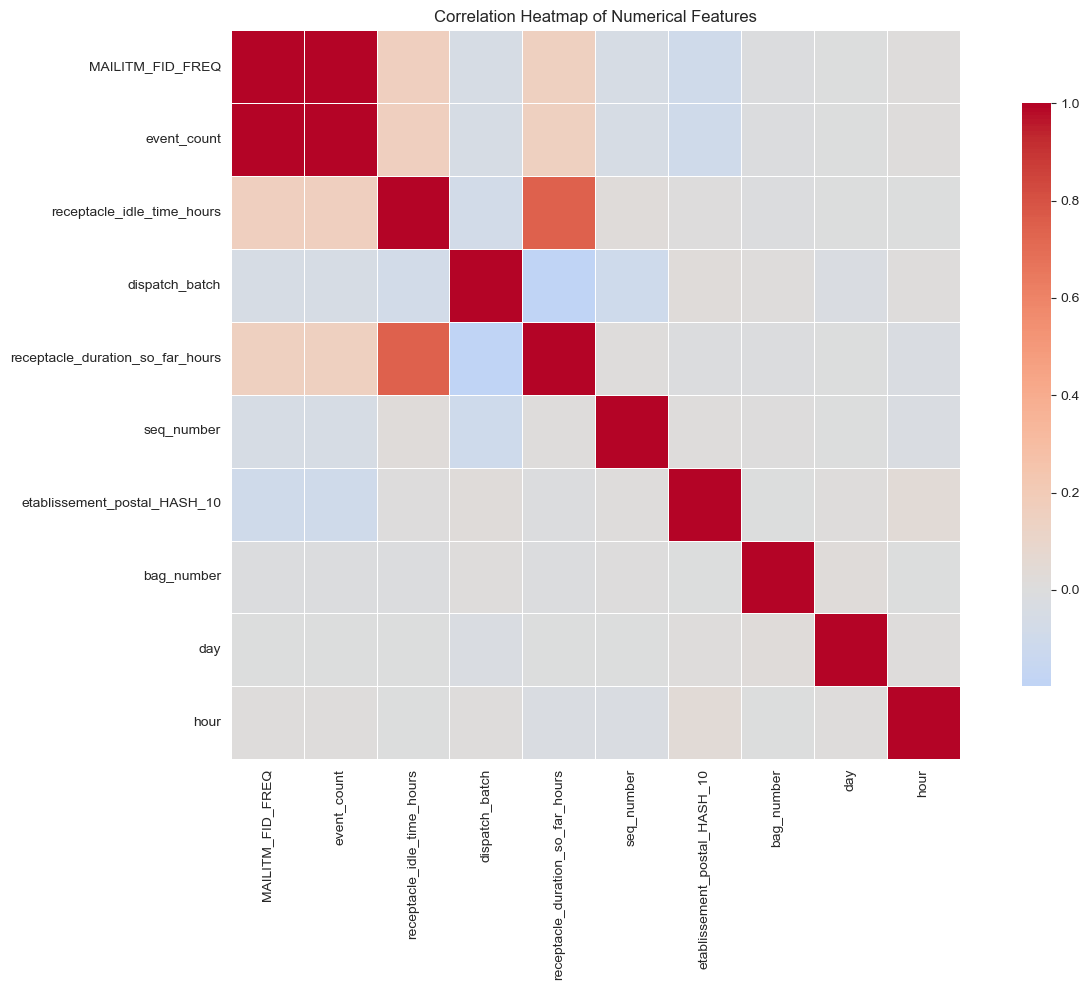

In [ ]:
# Correlation heatmap (all numerical features)
plt.figure(figsize=(14,10))
numerical_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

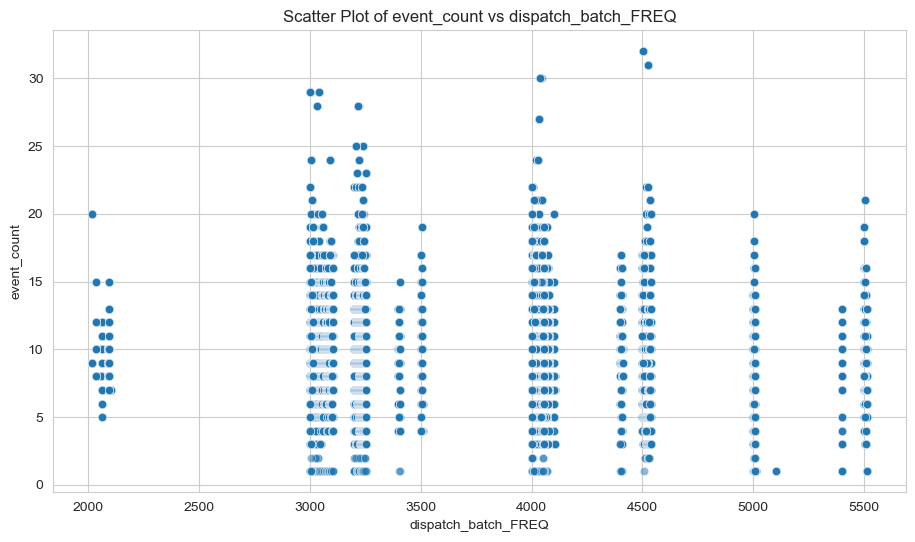

In [ ]:
# Scatter: event_count vs dispatch_batch
plt.figure(figsize=(11,6))
sns.scatterplot(x='dispatch_batch', y='event_count', data=df, alpha=0.5)
plt.title("Scatter Plot of event_count vs dispatch_batch_FREQ")
plt.xlabel("dispatch_batch_FREQ")
plt.ylabel("event_count")
plt.show()

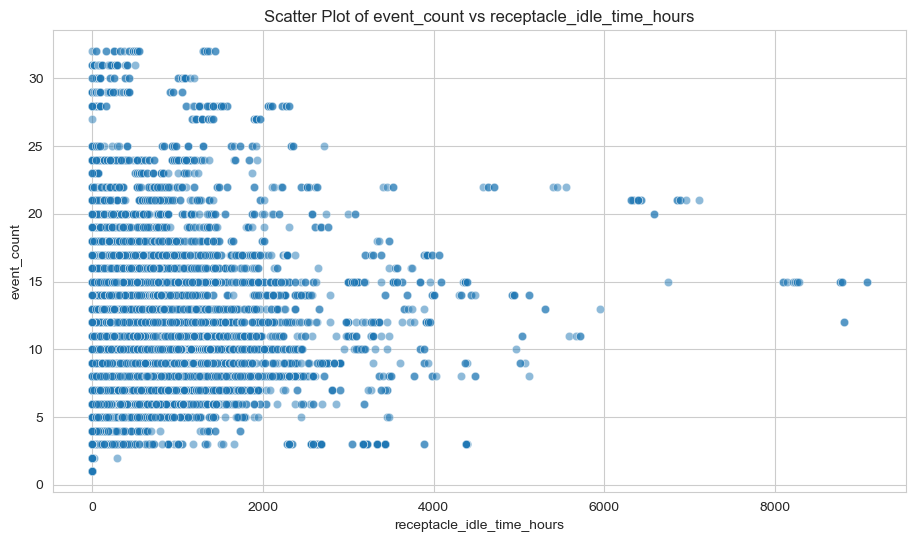

In [ ]:
# Scatter plot: event_count vs receptacle_idle_time_hours
plt.figure(figsize=(11,6))
sns.scatterplot(x='receptacle_idle_time_hours', y='event_count', data=df, alpha=0.5)
plt.title("Scatter Plot of event_count vs receptacle_idle_time_hours")
plt.xlabel("receptacle_idle_time_hours")
plt.ylabel("event_count")
plt.show()

# Observations:
-  high event counts concentrate at low idle times, while low event counts spread across all idle time ranges
- Most activity clustered at 0-2000 hours idle time with all event count levels, showing typical fast processing
- Extreme idle time outliers (6000-8000+ hours) only occur with low event counts (1-15), suggesting simple items get "forgotten" or stuck in queue longer

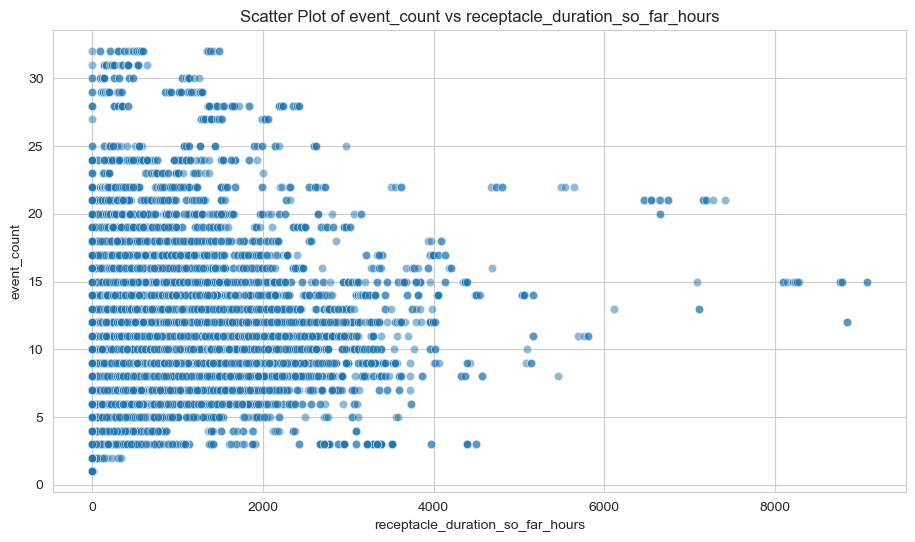

In [ ]:
# Scatter plot: event_count vs receptacle_duration_so_far_hours
plt.figure(figsize=(11,6))
sns.scatterplot(x='receptacle_duration_so_far_hours', y='event_count', data=df, alpha=0.5)
plt.title("Scatter Plot of event_count vs receptacle_duration_so_far_hours")
plt.xlabel("receptacle_duration_so_far_hours")
plt.ylabel("event_count")
plt.show()

# Observations:
- Inverse/negative relationship visible - higher event counts (20-32) cluster at lower durations (0-2000 hours), while lower event counts spread across all duration ranges
- Vertical banding at low durations (0-1000 hours) with all event_count levels, suggesting most items process quickly regardless of complexity
- High-duration outliers (4000-8000+ hours) only occur with low-to-medium event counts (1-22), indicating stuck/delayed items don't accumulate many events

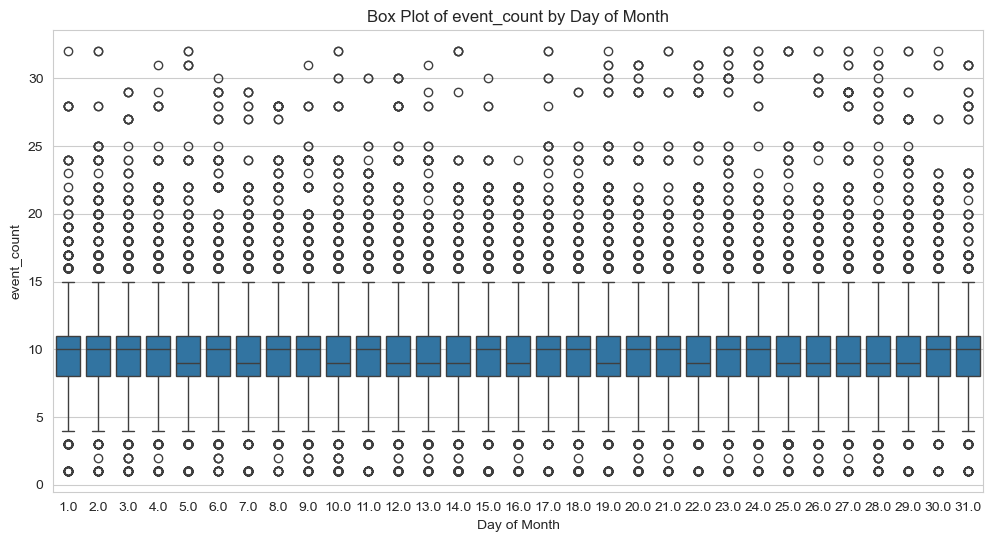

In [ ]:
#  Box plot: event_count by day (day of month)
plt.figure(figsize=(12,6))
sns.boxplot(x='day', y='event_count', data=df)
plt.title("Box Plot of event_count by Day of Month")
plt.xlabel("Day of Month")
plt.ylabel("event_count")
plt.show()

# Observations:
- Remarkably consistent pattern across all days - median stays at ~10 events, IQR spans 8-11 for every single day (1-31)
- No day-of-month effect detected - distributions are virtually identical, confirming operations don't vary by calendar date
- Uniform outlier patterns - all days show similar outlier counts at 15, 20, 25, 30+ events, indicating day-independent high-volume events

## summarize observations and insights of the distributions
- Perfect Correlation (Red): MAILITM_FID_FREQ and event_count are perfectly correlated (1.0) - they contain the same information, one should be dropped
- Weak Correlations Overall: Most features show very weak correlations (<0.3), indicating independent features - good for modeling diversity
- Moderate Relationships:
    dispatch_batch ↔ origin_country_FREQ (~0.3-0.4)
    seq_number ↔ origin_country_FREQ (~0.3)
These suggest operational grouping patterns
- No Temporal Dependencies: Time features (hour, day, day_of_week) show near-zero correlation with operational features - temporal and operational patterns are independent

## phase5: Advanced Insights 


goal is to detect operational patterns in sequence processing and identify outliers/anomalies that may indicate data quality issues, special cases, or opportunities for anomaly detection systems.

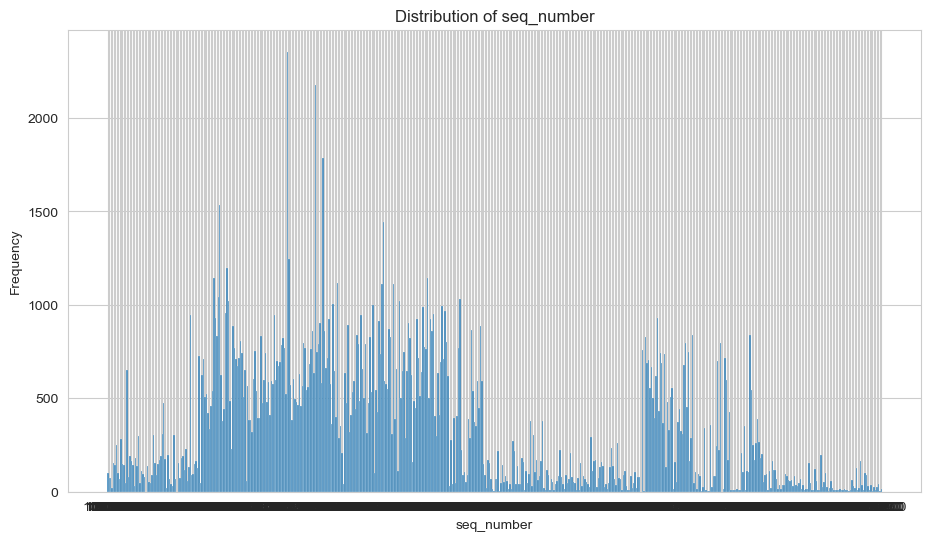

In [ ]:
# Sequence analysis: seq_number patterns
plt.figure(figsize=(11,6))
sns.histplot(df['seq_number'].astype(str), bins=10)
plt.title("Distribution of seq_number")
plt.xlabel("seq_number")
plt.ylabel("Frequency")
plt.show()

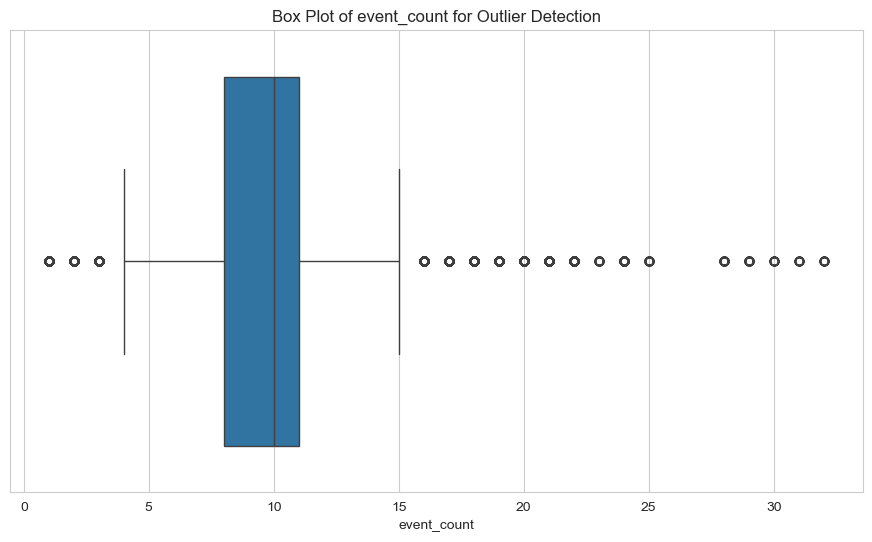

In [ ]:
# Outlier detection visualization
plt.figure(figsize=(11,6))
sns.boxplot(x=df['event_count'])
plt.title("Box Plot of event_count for Outlier Detection")
plt.xlabel("event_count")
plt.show()

## summarize observations and insights of the distributions
- dispatch_batch_FREQ vs event_count: Positive correlation; higher batch frequencies correspond to higher event counts, indicating busier batches handle more complex packages.
- seq_number_FREQ vs event_count: Moderate positive correlation; packages with higher sequence numbers tend to have more events, suggesting complex routing.
- Massive outlier presence: Values at 17, 20, 25, 30, 32 are all outliers
- These aren't errors - they represent legitimate high-volume events

## COMPLETE ANALYSIS SUMMARY

# Overall Data Characteristics:
- 173,794 postal mail tracking records spanning Nov 2022 - March 2025
- Operational data with strong temporal patterns and batch processing structure
- Two new critical duration metrics: receptacle idle time and processing duration
- Imbalanced features: établissement_postal_HASH_10 shows extreme concentration (93% in one bucket)
- Clean data quality: No missing values, outliers represent legitimate operational events

# Recommended Visualizations for Website Dashboard

- Real-Time Traffic Monitor: Live updating line chart of events per hour with baseline comparison
- Daily Operations Heatmap: Hourly event distribution by day of month showing peak operational windows
- Monthly Trend Line Chart: Monthly event volume trends with seasonal pattern indicators
- Receptacle Performance Dashboard: Dual-axis chart showing average idle time and processing duration trends
- Live Volume Gauge: Current event processing rate indicator with capacity threshold alerts
- Batch Processing Status: Real-time table of active dispatch batches with event counts and processing times

# Recommended Modeling/Prediction Tasks:

- Time Series Forecasting - Volume Prediction: Predict daily/hourly mail volume for next 7-30 days using temporal features (hour, day, month) for proactive resource allocation
- Receptacle Performance Optimization: Predict idle time and duration to identify bottlenecks and improve throughput efficiency
- High Volume Event Detection: Classify events as normal vs. high volume (event_count >15) for early warning capacity planning
- Anomaly Detection - Operational Irregularities: Detect unusual patterns in processing times, off-hour activity, and sequence breaks for quality control
- Delivery Time Estimation: Predict total delivery time based on initial events, receptacle metrics, and operational features for improved customer communication

# Critical Data Actions Required:

**Features to Drop:**
- MAILITM_FID_FREQ (perfect correlation with event_count, r=1.0)

**Features to Re-engineer:**
- établissement_postal_HASH_10: Failed hash distribution (93% in one bucket) - consider target encoding or frequency encoding
- bag_number: Apply log transformation or quantile binning due to extreme right-skew
- receptacle_idle_time_hours: Apply log transformation (log(x+1)) to handle extreme right-skew
- receptacle_duration_so_far_hours: Apply log transformation to normalize distribution

**Data Quality Investigations:**
- Extreme duration outliers: Investigate receptacles with >1000 hours (41+ days) idle time or processing duration
- Stuck items detection: Items with >4000 hours (~167 days) may indicate system failures or data quality issues
- Inverse relationship analysis: Understand why high event counts correlate with shorter processing times